<a href="https://colab.research.google.com/github/pparutto/BINF2025_TP7/blob/main/BINF2025_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BINF TP7 : analyse d'équilibre de flux métaboliques - FBA

Comme toutes les réactions métaboliques d'un organisme sont liées entre elles par leurs substrats / produits / cofacteurs, il est nécessaire de modéliser toutes les réactions d'un même organisme simultanément pour comprendre son métabolisme. On peut alors chercher quelles sont les réactions limitantes la production de certains composés ou la croissance d'un l'organisme.

Une telle méthode est l'analyse d'équilibre des fluxs métaboliques (Flux Balance Analysis -FBA) consistant à étudier le taux (flux) de matière passant au travers de chaque réactions métabolique d'un organisme.

L'élément de base de la FBA est une matrice de stoichiométrie $S$ décrivant les différentes réactions présentes dans un organisme. Chaque ligne représente un composé et chaque colonne une réaction, une valeur positive dans la matrice signifie que la réaction produit le composé correspondant et une valeur négative qu'elle le consomme.

Basé sur cette matrice, on cherche à trouver la distribution des flux de matière $v$ au travers de chaque réaction du réseau en considérant que le système est à l'équilibre

$$Sv = 0$$.

Cette hypothèse évite d'avoir à modéliser la dynamique des différentes réactions. A partir de là, on va résoudre ce système d'équations linéaires pour trouver $v$. Le problème est que le système est sous-spécifié car il possède plus de variables (réactions) que d'équations (composés). Il n'existe donc pas une unique solution. On va alors introduire un nouvel élément: une fonction objectif $f$ et chercher la distribution des flux maximisant $f$. La fonction $f$ est définie comme une combinaison linéaire des fluxs :

$$f = \sum\limits_{i=0}^N a_i v_i$$

où $a_i$ est un coefficient décrivant le poids du flux $v_i$ dans la fonction objectif. En particulier, on va souvent utiliser une fonction modélisant le taux de croissance de l'organisme, basée sur les réactions nécessaire à sa croissance. On peut alors résoudre le système par programation linéaire avec $f$ pour fonction objectif et un ensemble de contraintes de valeurs min et max des fluxs.

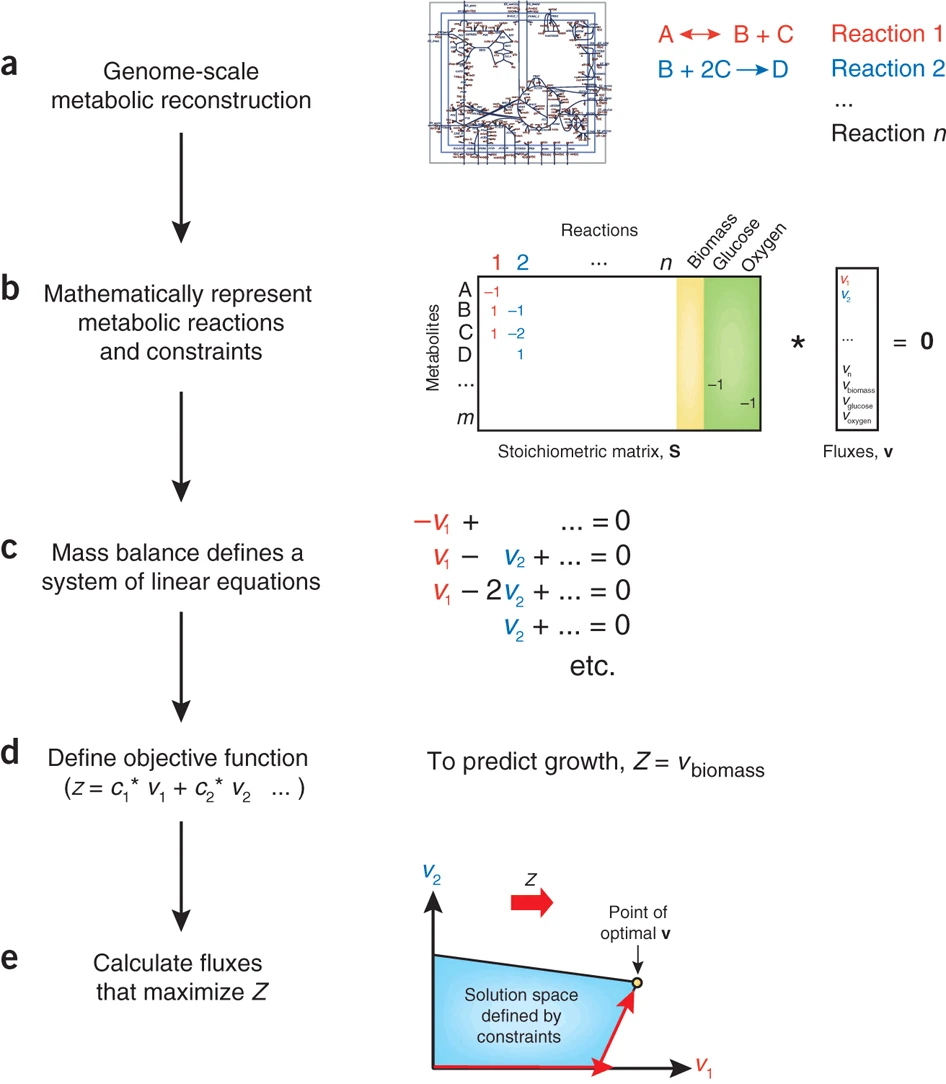

Pour ce TP, nous allons utiliser cobrapy pour optimiser les flux métaboliques et escher pour la visualisation. Installez ces packages via pip :

In [1]:
!pip install cobra escher

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.6 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 31.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.2/444.2 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 KB 3.6 MB/s eta 0

## Exercice 1 : Affichage et caractéristiques d'un modèle

Commençons par vérifier que tout fonctionne correctement:


1. Téléchargez la carte Escher du modèle « e_coli_core » depuis la base de données [BiGG](http://bigg.ucsd.edu).
2. Chargez cette carte via Escher en Python. Regardez la documentation ici : https://escher.readthedocs.io/en/latest/escher-python.html

In [14]:
import escher
from escher import Builder
import cobra
from time import sleep

# Load xml file
cobra_model = cobra.io.read_sbml_model('e_coli_core.xml')

builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model=cobra_model,
)


3. Sauvegardez un fichier html de cette carte et l’ouvrir dans un navigateur.

In [15]:
builder.save_html('example_map.html')

4.	Qu’observez-vous ?

**Votre réponse ici !!**

5. Combien de métabolites du sont présents dans le modèle ?

In [ ]:
print(len(cobra_model.metabolites))

72


6. Combien de réactions ?

In [ ]:
print(len(cobra_model.reactions))

95


7. Quel est le nom du métabolite qui participe au plus de réactions en tant que substrat ?

In [29]:
metabolite_c = {}
for reaction in cobra_model.reactions:
    for metabolite in reaction.metabolites:
        if metabolite.id not in metabolite_c:
            metabolite_c[metabolite.id] = 0
        metabolite_c[metabolite.id] += 1

max_metabolite = max(metabolite_c, key=metabolite_c.get)
met = cobra_model.metabolites.get_by_id(max_metabolite)
print(f'Metabolite with most reactions: {met.name} ({metabolite_c[max_metabolite]} reactions)')

Metabolite with most reactions: H+ (35 reactions)


8. Quel est le nom du métabolite qui participe au plus de réactions en tant que produit ?

In [32]:
product_counts = {}
for reaction in cobra_model.reactions:
    for met, stoich in reaction.metabolites.items():
        if stoich > 0:
            product_counts[met.id] = product_counts.get(met.id, 0) + 1

max_met_id = max(product_counts, key=product_counts.get)
max_count  = product_counts[max_met_id]

met = cobra_model.metabolites.get_by_id(max_met_id)

print(f"Le métabolite qui apparaît le plus souvent comme produit est '{met.name}' "
      f"(ID = {met.id}), avec {max_count} occurrences.")

Le métabolite qui apparaît le plus souvent comme produit est 'H+' (ID = h_c), avec 31 occurrences.


9. Affichez un histogramme présentant la distribution du nombre de réaction auquel participe chaque métabolite.

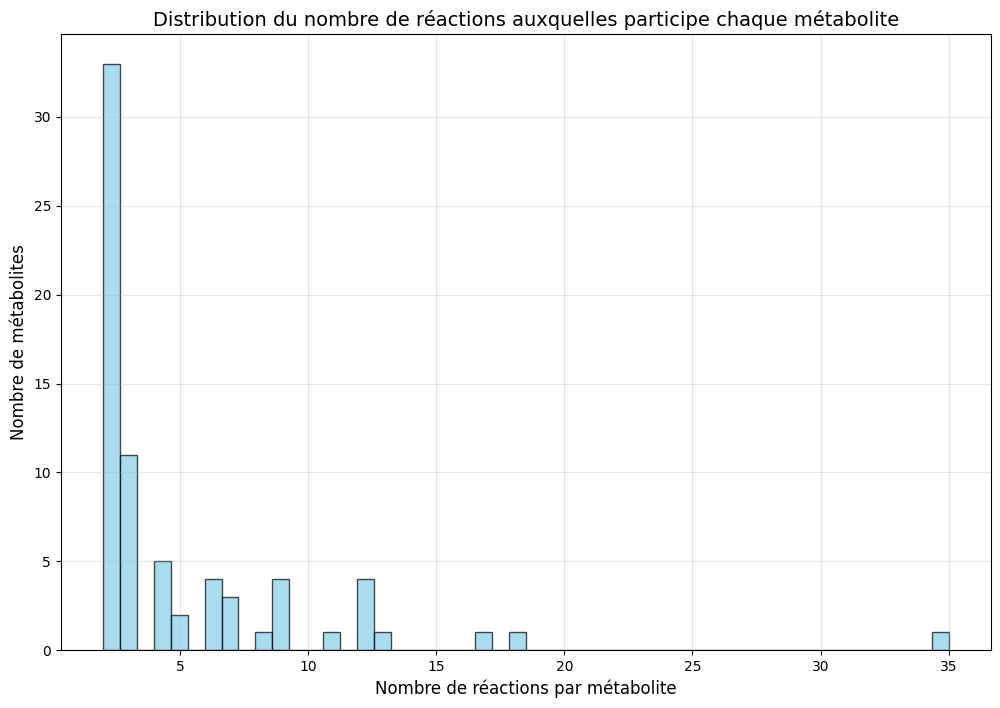

In [35]:
import matplotlib.pyplot as plt
import numpy as np

metabolite_reaction_counts = {}

for reaction in cobra_model.reactions:
    # Compter les réactifs
    for metabolite in reaction.reactants:
        if metabolite.id not in metabolite_reaction_counts:
            metabolite_reaction_counts[metabolite.id] = 0
        metabolite_reaction_counts[metabolite.id] += 1
    
    # Compter les produits
    for metabolite in reaction.products:
        if metabolite.id not in metabolite_reaction_counts:
            metabolite_reaction_counts[metabolite.id] = 0
        metabolite_reaction_counts[metabolite.id] += 1

# Convertir en liste des comptes
reaction_counts = list(metabolite_reaction_counts.values())

# Créer l'histogramme
plt.figure(figsize=(12, 8))
plt.hist(reaction_counts, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Nombre de réactions par métabolite', fontsize=12)
plt.ylabel('Nombre de métabolites', fontsize=12)
plt.title('Distribution du nombre de réactions auxquelles participe chaque métabolite', fontsize=14)
plt.grid(True, alpha=0.3)

## Exercice 2 : visualisation des flux métaboliques

Pour obtenir la distribution des flux métaboliques à partir d'un modèle, il faut choisir une fonction à optimiser. Cette fonction est une somme pondérée de concentrations de métabolites et l'on va chercher les flux au travers des réactions permettant de maximiser cette fonction. Pour étudier la capacité naturelle du métabolisme d'un organisme est une fonction représentant sa croissance.

1.	Téléchargez dans BiGG le modèle « e_coli_core » au format sbml associé à la carte que vous avez téléchargé dans la partie 1.
2. Chargez le modèle via Escher.

In [37]:
import escher
from escher import Builder
import cobra
from time import sleep

# Load xml file
cobra_model = cobra.io.read_sbml_model('e_coli_core.xml')

builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model=cobra_model,
)
builder.save_html('example_map2.html')

3. Optimisez les flux pour la fonction de croissance standard du modèle.

In [ ]:
# Optimisez le flux pour la fonction ded croissance standard du modèle

5.	Affichez les flux sur la carte du modèle :

In [ ]:
builder.reaction_data = solution.fluxes
builder.metabolite_data = solution.shadow_prices

6.	Sauvegardez la carte au format HTML.

In [ ]:
print("Votre code ici !!")

7.	Qu’observez-vous sur cette carte maintenant ?

**Votre réponse ici !!**

## Exercice 3 : etude de l'impact du milieu de culture sur la croissance d'E.coli

On va utiliser la FBA pour estimer l’impact de différents constituants du milieu de culture sur le taux de croissance d'E.coli. On peut avoir accès aux composés du milieu de culture dans notre modèle via l'attribut model.medium.

1. Trouver le composé du milieu correspondant au glucose et affichez un graphique présentant le taux de production de biomasse en fonction de la quantité de glucose dans le milieu de 1 à 1500.

Attention quand vous récuperrez le dictionnaire model.medium retourne une copie du dictionnaire du modèle, donc mod.medium["Ex_o2_e"] = 5 ne fait rien. A l’inverse, vous devez récupérer le dico, le modifier et le ré-affecter au modèle.

In [ ]:
print("Votre code ici !!")

2.	On va changer la source d’énergie en replaçant le glucose par du lactose dans le milieu de culture. Affichez la courbe du taux de production de biomasse en fonction de la quantité de lactose dans le milieu de 1 et 1500 en absence de glucose.

In [ ]:
print("Votre code ici !!")

3. Comparez avec les courbes des questions 1 et 2.

**Votre réponse ici !!**

4. On va maintenant se placer en condition anaérobique en supprimant l’oxygène du milieu de culture. Générez les courbes de croissance correspondante pour un milieu contenant uniquement du glucose ou du lactose (comme aux questions 1 et 2).

In [ ]:
print("Votre code ici !!")

Comparez les courbes des questions 1,2 et 4.

**Votre réponse ici !!**

# Exercice 4 : étude de l'effet de la suppression de gènes

Nous allons maintenant l'impacte de l'absence d'une enzyme sur le taux de croissance d'E.coli. Comme vu en cours, l'absence d'une enzyme implique la disparition de la réaction qu'elle catalyse.

1.	Pour chaque réaction du modèle, calculez le taux de production de biomasse après suppression de celle-ci.

In [ ]:
print("Votre code ici !!")

2.	Affichez les résultats sous forme d’un barplot où l'axe x contient chaque réaction supprimée et l'axe y le tau de prodution de biomasse associée.

In [ ]:
print("Votre code ici !!")

3.	Qu’observez-vous ? Quels sont les réactions nécessaires à la croissance ? Pouvez-vous comprendre pourquoi ?

**Votre réponse ici !!**

4.	Une réaction a un effet particulier, quelle est-elle et pouvez-vous pourquoi elle a cet effet ?

**Votre réponse ici !!**

## Exercice 5 : optimisation de la production d’un composé

Jusqu'à maintenant, on a considéré la fonction de création de biomasse (modélisant la croissance) comme fonction à optimisé. Cela nous a permi d'étudier le métabolisme naturel d'E.coli. On va maintenant se placer dans un cadre biotechnologique où on veut utiliser E.coli pour produire un composé d'intérêt.

On va utiliser le modèle métabolique étendu d'E.coli qui donne accès à un plus grand nombre de composés et réactions. Jusqu'à maintenant, nous avions utilisé le modèle "core" qui correspond uniquement au métabolisme central.

1.	Téléchargez et utilisez le modèle depuis iAF1260 BiGG.

In [ ]:
print("Votre code ici !!")

2.	Optimisez les flux métaboliques pour la fonction objectif du taux de production de biomasse. Quelle valeur obtenez-vous ?

In [ ]:
print("Votre code ici !!")

3.	On va maintenant chercher à maximiser la production de la molécule enterochelin (équivalente à l'enterobactine). Qu’est-ce que l’enterobactine ?

**Votre réponse ici !!**

4.	Trouvez la réaction produisant l’enterochelin dans le modèle.

In [ ]:
print("Votre code ici !!")

5.	Remplacez la fonction objectif du modèle par une fonction optimisant uniquement cette réaction.

In [ ]:
print("Votre code ici !!")

4.	Affichez la courbe d'évolution du taux de production d’enterochelin en fonction de la concentration en glucose dans le milieu entre 1 et 1500.

In [ ]:
print("Votre code ici !!")